# Instability space: joint histograms

Anna Mackie, 2024

This script produces the joint histograms of control simulation - perturbed simualtion entrainment-adjusted instability index. Also produces maps of different regions and mean cloud profiles of the different regions.

In [1]:
import sys
import pathlib
import platform
venv_path = '~/nb-venvs/metpy_venv'
sys.path.append(str(pathlib.Path(f'{venv_path}/lib/python{platform.python_version_tuple()[0]}.{platform.python_version_tuple()[1]}/site-packages/').expanduser()))

import metpy
print(metpy.__file__)

/opt/jaspy/lib/python3.11/site-packages/metpy/__init__.py


In [2]:
import numpy as np
import numpy.ma as ma
import cf
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from copy import copy
import glob
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.ndimage import gaussian_filter
import metpy.calc as mc
from metpy.units import units
import sys
#sys.path.append('../')
import functions as fns
import regionmask
import matplotlib.gridspec as gridspec


plt.rcParams.update({'font.size': 14})

lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']    

sst_inc = ['-4', '-3', '-2', '-1','+1', '+2', '+3', '+4']
sst_dig = [-4, -3, -2, -1, 1, 2, 3, 4]
patches = ['100E', '140E', '180E', '220E']
patch_title = [' 100$^{\circ}$E',  ' 140$^{\circ}$E',  ' 180$^{\circ}$E',  ' 220$^{\circ}$E']
cols = ['steelblue', 'deepskyblue', 'lightskyblue', 'powderblue','lightsalmon', 'darksalmon', 'tomato', 'red']#'
markers = ['o', 'd']
lines = ['-', '--']

def proportion_overcome_conv_threshold(hsfc, hsat500, weights, landmask):
    """ proportion of domain ascending using instability
    index, including area weighting
    """
    lon, month = hsfc.lon, hsfc.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(hsfc) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
    instab_index = hsfc - hsat500
    return weights_3Darray.where(instab_index > 0).sum() / weights_3Darray.sum()

def calc_ascent_frac(wap500, weights, landmask):
    """ proportion of domain ascending using vertical velocity
    at 500 hPa, including area weighting
    """
    lon, month = wap500.lon, wap500.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(wap500) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
                           
    return weights_3Darray.where(wap500 < 0).sum() / weights_3Darray.sum()

def calc_prop(arr, weights, landmask):
    lon, month = arr.lon, arr.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(arr) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
    return float(weights_3Darray.where(arr.notnull()==True).sum() / weights_3Darray.sum())
    
def bin2D(arr, var1, var2, bins1, bins2):
    """ arr = variable to be 2D binned
        var1 = the first variable you want to bin by
        var2 = the second variable you want to bin by
        b1 = the bins of the first variable
        b2 = the bins of the second variable
    """
    arr = np.asarray(arr)
    var1 = np.asarray(var1)
    var2 = np.asarray(var2)
    b1, b2 = len(bins1), len(bins2)
    R = np.empty((b2-1, b1-1)) # create an empty array for the 2D histogram
    A = np.empty((b2-1, b1-1))
    dig1 = np.digitize(var1, bins1) # bin by first variable. dig1 contains the indexes of the bins of each element
    
    for j in range(b1-1): # loop over these bins
        dig2= np.digitize(var2[dig1==j], bins2) # for each variable 1 bin, bin the selected gridpoints of variable 2 
        temp = arr[dig1==j] # array of the elements of arr which fall into bin j of binning by first variable
        R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)] 
        # fill empty array with the mean of arr which falls into both the variable 1 bin and variable 2 bin
        A[:,j] = [np.count_nonzero(temp[dig2==i]) for i in range(1,b2)]
        A[A==0] = np.nan
    A = A/np.nansum(A)
    return R, A     

def createR(arr, dig, b, weights):
    """
    calcs the mean value of the array in each bins (taken from dig)
    """
    arrbin = [arr.where(dig == i).weighted(weights).mean() for i in range(1,b)]
    return arrbin
    

def createA(dig, b, weights):
    """
    creates the normalised area pdf
    """
    num = [weights.where(dig == i).sum() for i in range(1,b)]
    A_bin = num/np.sum(num) # normalise
    return A_bin

# Constants, control, preamble

In [3]:
# constants
l = 20
g = metpy.constants.earth_gravity
cp = metpy.constants.dry_air_spec_heat_press
Lv = metpy.constants.water_heat_vaporization
Rv = metpy.constants.water_gas_constant
Md = metpy.constants.dry_air_molecular_weight
R0 = 8.31446261815324*units.joule / (units.K * units.mole)
Rd = metpy.constants.dry_air_gas_constant
epslion_i = 7E-5 / units.second
density = 1.15 *units.kilogram / (units.meter**3)
sst_change = [-4,-3,-2,-1,1,2,3,4]
patch_cols = ['red', 'green', 'orange','blue']
no_patches = len(patches)
no_temps = len(sst_dig)
deltaT_placeholder = 1



In [4]:
# make landmask and latitude weighting from control
ds = xr.open_dataset('data/control_2d.nc')
ds3d = xr.open_dataset('data/control_3d.nc')

lat = ds.lat.sel(lat = slice(-l,l))

#define land mask
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
weights = np.cos(np.deg2rad(lat))

SST = ds.ts.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
month, lat, lon = SST.month, SST.lat, SST.lon

In [5]:
adjustment_ctrl = np.load('entrainment_adjustments/adjustment_ctrl.npy')
adjustment_ctrl = xr.DataArray(adjustment_ctrl, dims=("month", "lat", "lon"), coords = (month, lat, lon))*units.joule / units.kilogram
ehat = 0.17746965 # taken from 'calc_entrain_adjust.ipynb'


#need to adjust landmask, as some coastal gridpoints have adjustment_ctrl = NaN as they don't have values for 1000hPa
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
landmask = xr.ones_like(SST).where(landmask.notnull()==False).where(adjustment_ctrl.notnull()==True)
landmask = xr.zeros_like(landmask).where(landmask !=1)


In [6]:
# define patch extent from delta SST from +4K experiments. 
for k in range(4):
        patch = patches[k]
        ds1 = xr.open_dataset('data/'+ patch +'_0N_+4K_2d.nc')
        SST1 = ds1.ts.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
    
        if k==0:
            patch_extents = (SST1 - SST).where((SST1 - SST) > 0.4)
            
        else:
            patch_extent1 = (SST1 - SST).where((SST1 - SST) > 0.4)
            patch_extents = xr.concat([patch_extents, patch_extent1], "newdim")

In [7]:
#control
zg_ctrl = ds3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
ta_ctrl = ds3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
q_ctrl = ds3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram
rh_ctrl = ds3d.hur.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
pfull_ctrl = ds3d.pfull.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.Pa
ps_ctrl = ds.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
ts_ctrl = ds.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
tas_ctrl = ds.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
dew2_ctrl = ds.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
pr_ctrl = ds.pr.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
q2m_ctrl = mc.specific_humidity_from_dewpoint(ps_ctrl, dew2_ctrl)
rh2m_ctrl = mc.relative_humidity_from_dewpoint(tas_ctrl, dew2_ctrl)

cf_ctrl = ds3d.cl.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
cli_ctrl = ds3d.cli.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
clw_ctrl = ds3d.clw.sel(lat = slice(-l,l)).where(landmask.notnull()==False)

p_in_hPa = ta_ctrl.plev/100

swcre_ctrl = ds.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
lwcre_ctrl = ds.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
netcre_ctrl = swcre_ctrl + lwcre_ctrl

#MSE
h_ctrl = mc.moist_static_energy(zg_ctrl, ta_ctrl, q_ctrl)
hsfc_ctrl = mc.moist_static_energy(2*units.m, tas_ctrl, q2m_ctrl)
hsfc_ctrl_adjusted = hsfc_ctrl -ehat*adjustment_ctrl

#MSE*
sat_mixing_ratio_ctrl = mc.saturation_mixing_ratio(pfull_ctrl, ta_ctrl)
sat_spec_hum_ctrl = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio_ctrl)
hsat_ctrl = mc.moist_static_energy(zg_ctrl, ta_ctrl, sat_spec_hum_ctrl)
hsat_ctrl_adjusted = (hsfc_ctrl  - ehat*adjustment_ctrl).where(landmask.notnull()==False)#hsfc_ctrl -ehat*adjustment_ctrl

hsat500_ctrl = hsat_ctrl.sel(plev = 50000.)
instability_ctrl = (hsfc_ctrl - hsat500_ctrl).where(landmask.notnull()==False)
instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)

wap_ctrl = ds3d.wap.sel(lat = slice(-l, l)) * units.Pa /units.second
wap500_ctrl = wap_ctrl.sel(plev = 50000.).where(landmask.notnull()==False)
alpha_up_ctrl = calc_ascent_frac(wap500_ctrl, weights, landmask)
w_up_ctrl = wap500_ctrl.where(wap500_ctrl <0).weighted(weights).mean()

ts_ctrl = ds.ts.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K

uas_ctrl = ds.uas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
vas_ctrl = ds.vas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
wind_div_ctrl = mc.divergence(uas_ctrl, vas_ctrl)

vdotgradq_ctrl = mc.geospatial_gradient(q2m_ctrl)[0]*uas_ctrl + mc.geospatial_gradient(q2m_ctrl)[1]*vas_ctrl

lat, lon = ts_ctrl.lat, ts_ctrl.lon
months = ts_ctrl.month


## Joint histogram-type plots

### Fig 3: PDF and netCRE 

Main text plot. 

Top two rows: PDF for two patches (180E and 220E) for the +2K perturbation. Also how the proportions change over the temperature range

Bottom two rows: Colorscale is $\Delta$CRE_{net} on the joint histograms for the +2K simulations. Also how the quadrants contribute to the tropical mean trend.

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


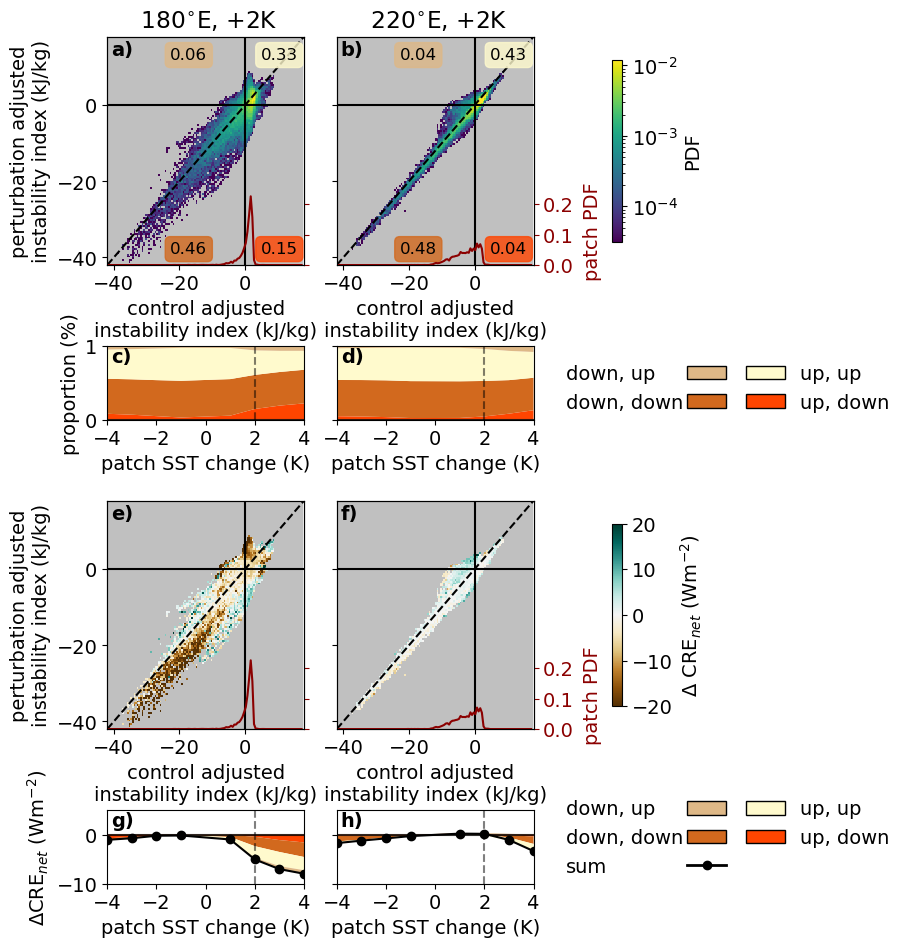

In [12]:
# this plot gets squashed by the legends, so increase font size
plt.rcParams.update({'font.size': 14})

lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)'] 
gs = gridspec.GridSpec(6, 4)

fig = plt.figure()
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.92, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.92, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.78, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.78, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.92, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.92, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.78, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.78, lets[7], transform=ax15.transAxes, weight = 'bold')

lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)
month = 2
temp_select = 5
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    dig_ctrl = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_adjusted), bins)* units.dimensionless
    dig_ctrl = xr.DataArray(dig_ctrl, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_ctrl = np.asarray(createA(dig_ctrl, b, weights))


    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))


    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500
        

        # joint histograms: PDF and delta_netcre
        if j == temp_select:
            
            R, A = bin2D(delta_netcre, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            if c==0:
                cmin, cmax = np.nanmin(A), np.nanmax(A)
            cs1 = ax[c].pcolormesh(mnbin, mnbin, A, norm=colors.LogNorm(vmin =cmin, vmax = cmax))
            cs2 = axrow3[c].pcolormesh(mnbin, mnbin, R, vmin = -20, vmax = 20, cmap = 'BrBG')
 
            if k==3:
                plt.colorbar(cs1, ax = ax[c], cax = ax[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = 'PDF')
                plt.colorbar(cs2, ax = axrow3[c], cax = axrow3[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = '$\Delta$ CRE$_{net}$ (Wm$^{-2}$)')
    
            
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                if mm == ax[c]:
                    mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                            transform=mm.transAxes, color = 'k',fontsize = 12,  bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                    mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k',fontsize = 12,  bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                    mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                    mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
            
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                
                #ax_twin.plot([0,0,], patch_lim, 'k-', alpha = 0.5)
                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.25, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
      
        cont_up_down_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_netcre.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_2[c,j] = delta_netcre.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_2[c,j] = delta_netcre.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_2[c,j] = delta_netcre.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_2[c,j] = float(delta_netcre.weighted(weights).mean())
        
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": total_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        if nn == axrow4[c]:
            l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[0,1], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].set_xticks(np.arange(-4, 5, 2))
    axrow4[c].set_xticks(np.arange(-4, 5, 2))
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)

    c+=1

ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('proportion (%)')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta$CRE$_{net}$ (Wm$^{-2}$)')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [0,1],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-10, 5] ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.1, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
labels1 = ['down, up', 'down, down', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, p4, p2,  p3, p1], labels1, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
fig.savefig('newplots/Fig3.png', bbox_inches = 'tight', dpi = 300)



### Fig S4: As Fig 3 but for -2K

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


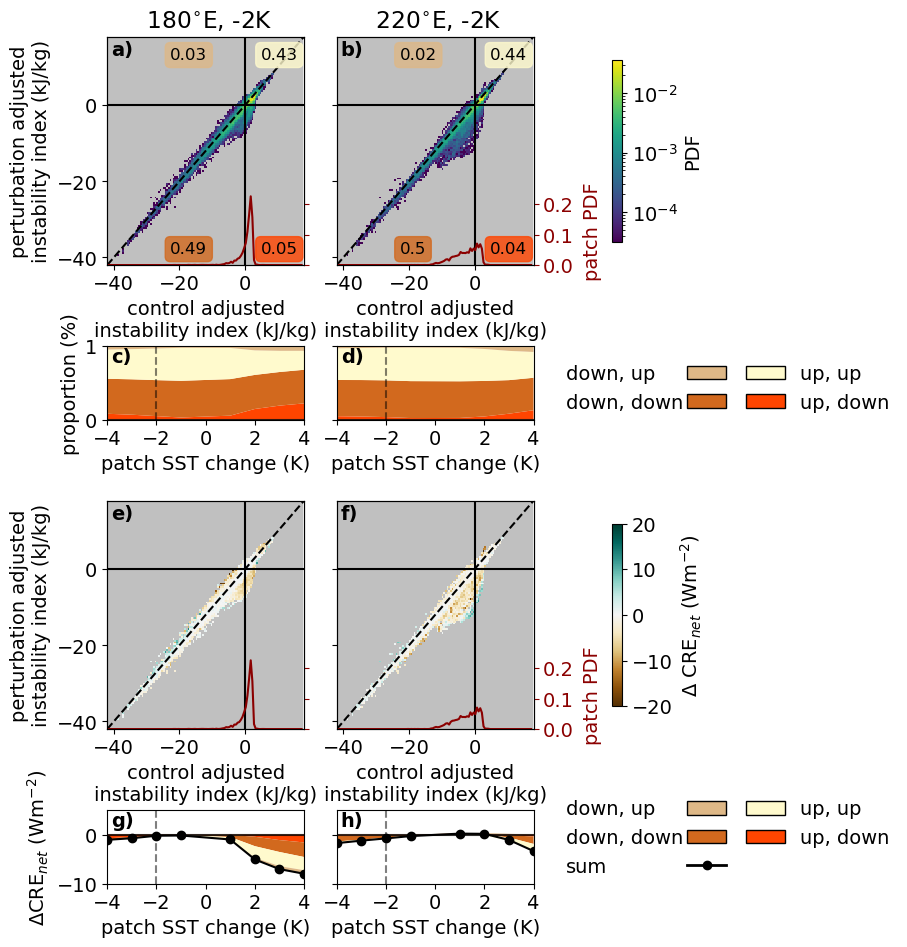

In [14]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)'] 
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(6, 4)

fig = plt.figure()
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.92, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.92, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.78, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.78, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.92, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.92, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.78, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.78, lets[7], transform=ax15.transAxes, weight = 'bold')

lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)
month = 2
temp_select = 2
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    dig_ctrl = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_adjusted), bins)* units.dimensionless
    dig_ctrl = xr.DataArray(dig_ctrl, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_ctrl = np.asarray(createA(dig_ctrl, b, weights))


    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))


    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)

        instability_adjusted = hsfc_adjusted - hsat500
        

        #plot for one j
        if j == temp_select:
            
            R, A = bin2D(delta_netcre, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            if c==0:
                cmin, cmax = np.nanmin(A), np.nanmax(A)
            cs1 = ax[c].pcolormesh(mnbin, mnbin, A, norm=colors.LogNorm(vmin =cmin, vmax = cmax))
            cs2 = axrow3[c].pcolormesh(mnbin, mnbin, R, vmin = -20, vmax = 20, cmap = 'BrBG')
 
            if k==3:
                plt.colorbar(cs1, ax = ax[c], cax = ax[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = 'PDF')
                plt.colorbar(cs2, ax = axrow3[c], cax = axrow3[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = '$\Delta$ CRE$_{net}$ (Wm$^{-2}$)')
    
            
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                if mm == ax[c]:
                    mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                    mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                    mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                    mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                            transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
            
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                

                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.25, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
  
        cont_up_down_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_1[c,j] = calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_netcre.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_2[c,j] = delta_netcre.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_2[c,j] = delta_netcre.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_2[c,j] = delta_netcre.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_2[c,j] = float(delta_netcre.weighted(weights).mean())


        
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": total_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        if nn == axrow4[c]:
            l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[0,1], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow2[c].set_xticks(np.arange(-4, 5, 2))
    axrow4[c].set_xticks(np.arange(-4, 5, 2))
    c+=1


ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('proportion (%)')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta$CRE$_{net}$ (Wm$^{-2}$)')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [0,1],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-10, 5] ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.1, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
labels1 = ['down, up', 'down, down', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, p4, p2,  p3, p1], labels1, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
fig.savefig('newplots/SIFig4.png', bbox_inches = 'tight', dpi = 300)

### Fig S5: without patch and patch only 

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


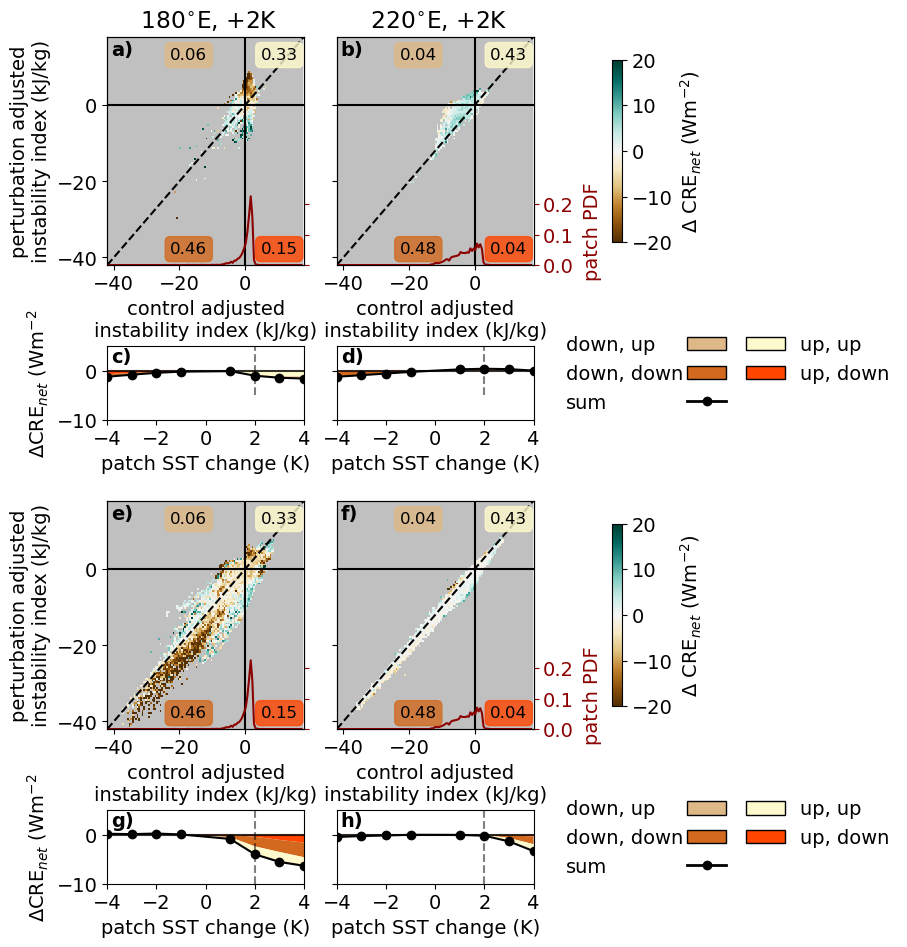

In [17]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']   
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(6, 4)

fig = plt.figure()
fig.set_size_inches(8,16)
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.92, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.92, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.78, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.78, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.92, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.92, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.78, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.78, lets[7], transform=ax15.transAxes, weight = 'bold')

lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]


temp_select = 5
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))

    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        delta_lwcre = lwcre - lwcre_ctrl
        delta_swcre = swcre - swcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        #without patch
        delta_netcre_np = delta_netcre.where(patch_ex.notnull()==False)
        instability_ctrl_adjusted_np = instability_ctrl_adjusted.where(patch_ex.notnull()==False)
        instability_adjusted_np = instability_adjusted.where(patch_ex.notnull()==False)

        #without patch
        delta_netcre_po = delta_netcre.where(patch_ex.notnull()==True)
        instability_ctrl_adjusted_po = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
        instability_adjusted_po = instability_adjusted.where(patch_ex.notnull()==True)

        #plot for one j
        if j == temp_select:
            
            Rpo, Apo = bin2D(delta_netcre_po, instability_ctrl_adjusted_po, instability_adjusted_po, bins,bins)# patch only
            Rnp, Anp = bin2D(delta_netcre_np, instability_ctrl_adjusted_np, instability_adjusted_np, bins,bins) # no patch
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            #if k==0:
            #    cmin, cmax = np.nanmin(A), np.nanmax(A)
            cs = ax[c].pcolormesh(mnbin, mnbin, Rpo, vmin = -20, vmax = 20, cmap = 'BrBG')
            cs3 = axrow3[c].pcolormesh(mnbin, mnbin, Rnp, vmin = -20, vmax = 20, cmap = 'BrBG')
            
            if k==3:
                plt.colorbar(cs, ax = ax[c], cax = ax[c].inset_axes([1.4, 0.1, 0.05, 0.8]),  label = '$\Delta$ CRE$_{net}$ (Wm$^{-2}$)')
                plt.colorbar(cs3, ax = axrow3[c], cax = axrow3[c].inset_axes([1.4, 0.1, 0.05, 0.8]),label = '$\Delta$ CRE$_{net}$ (Wm$^{-2}$)')
          
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
            
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                
                #ax_twin.plot([0,0,], patch_lim, 'k-', alpha = 0.5)
                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.25, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')

        
        cont_up_down_1[c,j] = delta_netcre_po.where(instability_ctrl_adjusted_po>0).where(instability_adjusted_po<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_po.where(instability_ctrl_adjusted_po>0).where(instability_adjusted_po<0), weights,landmask)
        cont_up_up_1[c,j] = delta_netcre_po.where(instability_ctrl_adjusted_po>0).where(instability_adjusted_po>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_po.where(instability_ctrl_adjusted_po>0).where(instability_adjusted_po>0), weights,landmask)
        cont_down_down_1[c,j] = delta_netcre_po.where(instability_ctrl_adjusted_po<0).where(instability_adjusted_po<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_po.where(instability_ctrl_adjusted_po<0).where(instability_adjusted_po<0), weights,landmask)
        cont_down_up_1[c,j] = delta_netcre_po.where(instability_ctrl_adjusted_po<0).where(instability_adjusted_po>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_po.where(instability_ctrl_adjusted_po<0).where(instability_adjusted_po>0), weights,landmask)
        total_1[c,j] = float(delta_netcre_po.weighted(weights).mean())
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_netcre_np.where(instability_ctrl_adjusted_np>0).where(instability_adjusted_np<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_np.where(instability_ctrl_adjusted_np>0).where(instability_adjusted_np<0), weights,landmask)
        cont_up_up_2[c,j] = delta_netcre_np.where(instability_ctrl_adjusted_np>0).where(instability_adjusted_np>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_np.where(instability_ctrl_adjusted_np>0).where(instability_adjusted_np>0), weights,landmask)
        cont_down_down_2[c,j] = delta_netcre_np.where(instability_ctrl_adjusted_np<0).where(instability_adjusted_np<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_np.where(instability_ctrl_adjusted_np<0).where(instability_adjusted_np<0), weights,landmask)
        cont_down_up_2[c,j] = delta_netcre_np.where(instability_ctrl_adjusted_np<0).where(instability_adjusted_np>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted_np.where(instability_ctrl_adjusted_np<0).where(instability_adjusted_np>0), weights,landmask)
        total_2[c,j] = float(delta_netcre_np.weighted(weights).mean())
        sum_2[c,j] = cont_up_down_2[c,j] + cont_up_up_2[c,j] + cont_down_down_2[c,j] + cont_down_up_2[c,j]
      
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": sum_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-5,5], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow2[c].set_xticks(np.arange(-4, 5, 2))
    axrow4[c].set_xticks(np.arange(-4, 5, 2))
    c+=1


ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('$\Delta$CRE$_{net}$ (Wm$^{-2}$')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta$CRE$_{net}$ (Wm$^{-2}$')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [-10,5],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-10, 5] ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.1, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, px3, p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
fig.savefig('newplots/SIFig5.png', bbox_inches = 'tight', dpi = 300)

### Fig S6: $\Delta h^*_{500}$ and advective drying 

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


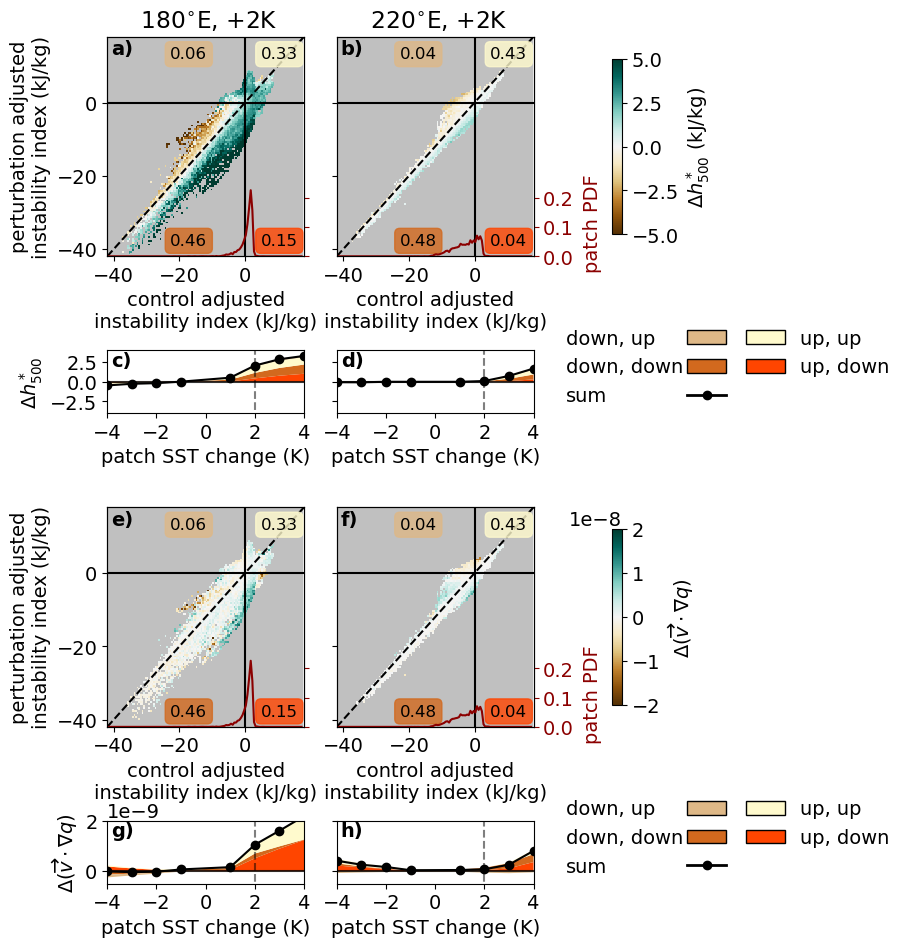

In [15]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']   
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(6, 4)
fig = plt.figure()
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.92, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.92, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.75, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.75, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.92, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.92, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.75, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.75, lets[7], transform=ax15.transAxes, weight = 'bold')


lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]


temp_select = 5
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))

    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        delta_lwcre = lwcre - lwcre_ctrl
        delta_swcre = swcre - swcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio

        uas = ds1.uas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
        vas = ds1.vas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
        
        vdotgradq = mc.geospatial_gradient(q2m)[0]*uas + mc.geospatial_gradient(q2m)[1]*vas
        delta_vdotgradq = (vdotgradq - vdotgradq_ctrl) 
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        delta_hsat500 = hsat500- hsat500_ctrl
        instability_adjusted = hsfc_adjusted - hsat500
        

        #plot for one j
        if j == temp_select:
            
            R1, A1 = bin2D(delta_hsat500, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            R2, A2 = bin2D(delta_vdotgradq, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            
            cs1 = ax[c].pcolormesh(mnbin, mnbin, R1, vmin =-5, vmax = 5, cmap = 'BrBG')
            cs2 = axrow3[c].pcolormesh(mnbin, mnbin, R2, vmin = -2E-8, vmax = 2E-8, cmap = 'BrBG')
            
            if k==3:
                plt.colorbar(cs1, ax = ax[c], cax = ax[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = '$\Delta h^*_{500}$ (kJ/kg)')
                plt.colorbar(cs2, ax = axrow3[c], cax = axrow3[c].inset_axes([1.4, 0.1, 0.05, 0.8]), label = '$\Delta (\overrightarrow{v} \cdot \\nabla q)$')
          
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                
                mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                        transform=mm.transAxes, color = 'k', fontsize = 12,  bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
                
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                
                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.25, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')

        
        cont_up_down_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_1[c,j] = float(delta_hsat500.weighted(weights).mean())
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_2[c,j] = float(delta_vdotgradq.weighted(weights).mean())
        sum_2[c,j] = cont_up_down_2[c,j] + cont_up_up_2[c,j] + cont_down_down_2[c,j] + cont_down_up_2[c,j]
      
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": sum_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-5,5], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow2[c].set_xticks(np.arange(-4, 5, 2))
    axrow4[c].set_xticks(np.arange(-4, 5, 2))
    c+=1


ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('$\Delta h^*_{500} $')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta (\overrightarrow{v} \cdot \\nabla q)$')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [-4,4],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-0.5E-9, 2E-9]  ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.5, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
#labels1 = ['down, up', 'down, down', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, px3, p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
fig.savefig('newplots/SIFig6.png', bbox_inches = 'tight', dpi = 300)

### Not in manuscript: control simulation advective drying

to check the sign of the control simulation advective drying. First two rows unchanged from S6.

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


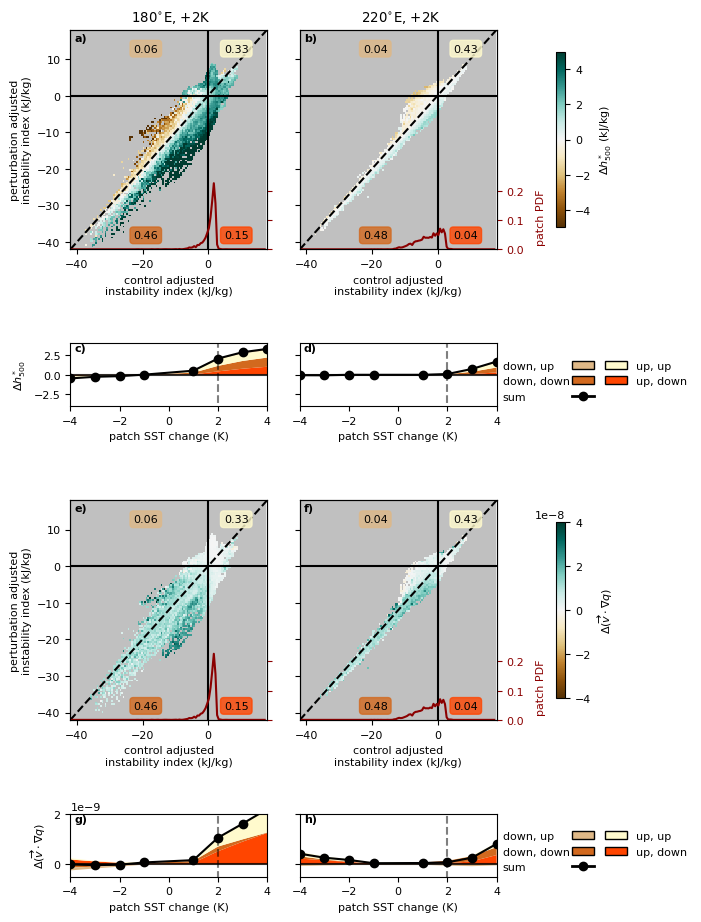

In [24]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']   
gs = gridspec.GridSpec(6, 4)
fig = plt.figure()
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.95, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.95, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.87, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.87, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.95, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.95, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.87, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.87, lets[7], transform=ax15.transAxes, weight = 'bold')


lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]


temp_select = 5
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))

    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        delta_lwcre = lwcre - lwcre_ctrl
        delta_swcre = swcre - swcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio

        uas = ds1.uas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
        vas = ds1.vas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
        
        vdotgradq = mc.geospatial_gradient(q2m)[0]*uas + mc.geospatial_gradient(q2m)[1]*vas
        delta_vdotgradq = (vdotgradq - vdotgradq_ctrl) 
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        delta_hsat500 = hsat500- hsat500_ctrl
        instability_adjusted = hsfc_adjusted - hsat500
        

        #plot for one j
        if j == temp_select:
            
            R1, A1 = bin2D(delta_hsat500, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            R2, A2 = bin2D(vdotgradq_ctrl, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            
            cs1 = ax[c].pcolormesh(mnbin, mnbin, R1, vmin =-5, vmax = 5, cmap = 'BrBG')
            cs2 = axrow3[c].pcolormesh(mnbin, mnbin, R2, vmin = -4E-8, vmax = 4E-8, cmap = 'BrBG')
            
            if k==3:
                plt.colorbar(cs1, ax = ax[c], cax = ax[c].inset_axes([1.3, 0.1, 0.05, 0.8]), label = '$\Delta h^*_{500}$ (kJ/kg)')
                plt.colorbar(cs2, ax = axrow3[c], cax = axrow3[c].inset_axes([1.3, 0.1, 0.05, 0.8]), label = '$\Delta (\overrightarrow{v} \cdot \\nabla q)$')
          
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                
                mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                        transform=mm.transAxes, color = 'k', bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
                
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                
                #ax_twin.plot([0,0,], patch_lim, 'k-', alpha = 0.5)
                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.2, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')

        
        cont_up_down_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_1[c,j] = delta_hsat500.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_1[c,j] = float(delta_hsat500.weighted(weights).mean())
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_2[c,j] = delta_vdotgradq.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_2[c,j] = float(delta_vdotgradq.weighted(weights).mean())
        sum_2[c,j] = cont_up_down_2[c,j] + cont_up_up_2[c,j] + cont_down_down_2[c,j] + cont_down_up_2[c,j]
      
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": sum_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-5,5], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)

    c+=1


ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('$\Delta h^*_{500} $')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta (\overrightarrow{v} \cdot \\nabla q)$')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [-4,4],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-0.5E-9, 2E-9]  ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.5, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, px3, p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
#fig.savefig('newplots/SIFig6.png', bbox_inches = 'tight', dpi = 300)

### Fig S9: $\Delta$CRE$_{LW}$ and $\Delta$CRE$_{SW}$

no of instability bins:  120


/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]
/tmp/ipykernel_621/179703323.py:93: RuntimeWarning: Mean of empty slice
  R[:,j] = [np.nanmean(temp[dig2==i]) for i in range(1, b2)]


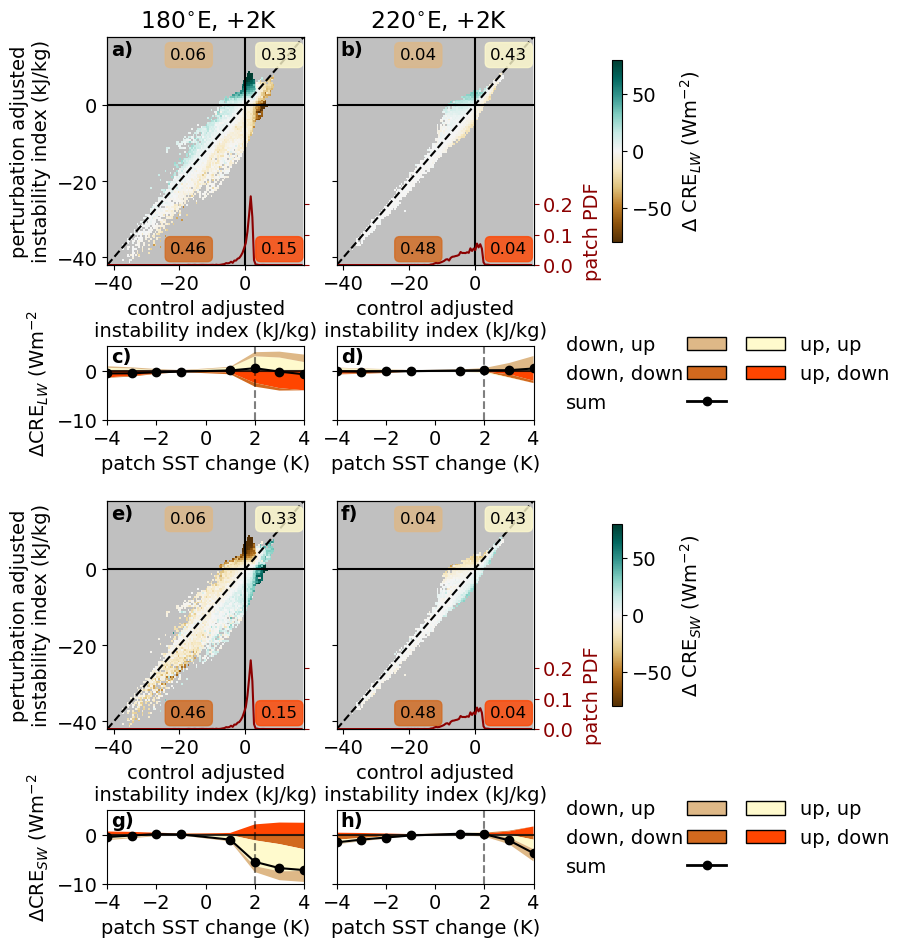

In [16]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)'] 
plt.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(6, 4)

fig = plt.figure()
ax1 = plt.subplot(gs[0:2, 0:2])
ax1.text(0.02, 0.92, lets[0], transform=ax1.transAxes, weight = 'bold')
ax3 = plt.subplot(gs[0:2, 2:4]) 
ax3.text(0.02, 0.92, lets[1], transform=ax3.transAxes, weight = 'bold')
ax5 = plt.subplot(gs[2, 0:2])
ax5.text(0.02, 0.78, lets[2], transform=ax5.transAxes, weight = 'bold')
ax7 = plt.subplot(gs[2, 2:4])
ax7.text(0.02, 0.78, lets[3], transform=ax7.transAxes, weight = 'bold')

ax9 = plt.subplot(gs[3:5, 0:2]) 
ax9.text(0.02, 0.92, lets[4], transform=ax9.transAxes, weight = 'bold')
ax11 = plt.subplot(gs[3:5, 2:4])  
ax11.text(0.02, 0.92, lets[5], transform=ax11.transAxes, weight = 'bold')
ax13 = plt.subplot(gs[5, 0:2])
ax13.text(0.02, 0.78, lets[6], transform=ax13.transAxes, weight = 'bold')
ax15 = plt.subplot(gs[5, 2:4])
ax15.text(0.02, 0.78, lets[7], transform=ax15.transAxes, weight = 'bold')



lim = [-42, 18]
color = 'k'
cont_up_down_1, cont_up_up_1, cont_down_up_1, cont_down_down_1, sum_1, total_1 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
cont_up_down_2, cont_up_up_2, cont_down_up_2, cont_down_down_2, sum_2, total_2 = np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8)),np.empty((4,8))
section_colors = ['orangered', 'chocolate', 'lemonchiffon', 'burlywood']

ax= [ax1, ax3]
axrow2 = [ax5, ax7]

axrow3= [ax9, ax11]
axrow4 = [ax13, ax15]

pl = lim[1] # pos limit
nlim= lim[0] # neg limit
bs = 0.5# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of instability bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]


temp_select = 5
c = 0
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    instability_ctrl_patch = instability_ctrl_adjusted.where(patch_ex.notnull()==True)
    dig_patch = xr.apply_ufunc(np.digitize, np.asarray(instability_ctrl_patch), bins)* units.dimensionless
    dig_patch = xr.DataArray(dig_patch, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch = np.asarray(createA(dig_patch, b, weights))

    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        delta_lwcre = lwcre - lwcre_ctrl
        delta_swcre = swcre - swcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500
        

        #plot for one j
        if j == temp_select:
            
            Rlw, Alw = bin2D(delta_lwcre, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            Rsw, Asw = bin2D(delta_swcre, instability_ctrl_adjusted, instability_adjusted, bins,bins)
            ax[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            axrow3[c].pcolormesh(bins, bins, np.ones((b,b)), cmap = 'gist_gray', vmin = -2, vmax = 2)
            #if k==0:
            #    cmin, cmax = np.nanmin(A), np.nanmax(A)
            cs = ax[c].pcolormesh(mnbin, mnbin, Rlw, vmin = -80, vmax = 80, cmap = 'BrBG')
            cs3 = axrow3[c].pcolormesh(mnbin, mnbin, Rsw, vmin = -80, vmax = 80, cmap = 'BrBG')
            
            if k==3:
                plt.colorbar(cs, ax = ax[c], cax = ax[c].inset_axes([1.4, 0.1, 0.05, 0.8]),  label = '$\Delta$ CRE$_{LW}$ (Wm$^{-2}$)')
                plt.colorbar(cs3, ax = axrow3[c], cax = axrow3[c].inset_axes([1.4, 0.1, 0.05, 0.8]),label = '$\Delta$ CRE$_{SW}$ (Wm$^{-2}$)')
          
            #formatting
            for mm in [ax[c], axrow3[c]]:
        
                mm.plot(lim, lim, 'k--',)
                mm.plot(lim, [0,0], 'k-')
                mm.plot( [0,0],lim, 'k-')
                
                
                mm.text(0.78, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask),2)),
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[0], fc=section_colors[0], alpha = 0.8))
                mm.text(0.78, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[2], fc=section_colors[2], alpha = 0.8))
                mm.text(0.32, 0.05, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[1], fc=section_colors[1], alpha = 0.8))
                mm.text(0.32, 0.9, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask),2)), 
                        transform=mm.transAxes, color = 'k', fontsize = 12, bbox=dict(boxstyle="round", ec=section_colors[3], fc=section_colors[3], alpha = 0.8))
            
                ax_twin = mm.twinx()
                ax_twin.plot(mnbin, A_patch, '-', color = 'darkred')
                ax_twin.tick_params(axis='y', colors='darkred')
                
                #ax_twin.plot([0,0,], patch_lim, 'k-', alpha = 0.5)
                ax_twin.set_ylim([0, 0.75])
                if k==3:
                    ax_twin.set_ylabel('patch PDF')
                    ax_twin.yaxis.set_label_coords(1.25, 0.15, transform=ax_twin.transAxes)
                    ax_twin.yaxis.label.set_color('darkred')
                    ax_twin.set_yticks([0,0.1,0.2])
                else:
                    ax_twin.set_yticklabels('')
                    ax_twin.set_yticks([0,0.1,0.2])
                    
                if k==3:
                    mm.set_yticklabels('')
                
            ax[c].set_title(patch_title[k] + ', ' + delta_sst + 'K')
            ax[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')
            axrow3[c].set_xlabel('control adjusted\ninstability index (kJ/kg)')

        
        cont_up_down_1[c,j] = delta_lwcre.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_1[c,j] = delta_lwcre.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_1[c,j] = delta_lwcre.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_1[c,j] = delta_lwcre.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_1[c,j] = float(delta_lwcre.weighted(weights).mean())
        sum_1[c,j] = cont_up_down_1[c,j] + cont_up_up_1[c,j] + cont_down_down_1[c,j] + cont_down_up_1[c,j]
        
        cont_up_down_2[c,j] = delta_swcre.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted<0), weights,landmask)
        cont_up_up_2[c,j] = delta_swcre.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(instability_adjusted>0), weights,landmask)
        cont_down_down_2[c,j] = delta_swcre.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted<0), weights,landmask)
        cont_down_up_2[c,j] = delta_swcre.where(instability_ctrl_adjusted<0).where(instability_adjusted>0).weighted(weights).mean()*calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(instability_adjusted>0), weights,landmask)
        total_2[c,j] = float(delta_swcre.weighted(weights).mean())
        sum_2[c,j] = cont_up_down_2[c,j] + cont_up_up_2[c,j] + cont_down_down_2[c,j] + cont_down_up_2[c,j]
      
    df1 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_1[c,], 
                       "up_down": cont_up_down_1[c,],
                       "up_up": cont_up_up_1[c,], 
                       "down_up": cont_down_up_1[c,],
                       "total": sum_1[c,]})

    df2 = pd.DataFrame({"sst_inc": sst_dig, 
                       "down_down": cont_down_down_2[c,], 
                       "up_down": cont_up_down_2[c,],
                       "up_up": cont_up_up_2[c,], 
                       "down_up": cont_down_up_2[c,],
                       "total": sum_2[c,]})

    for nn in [axrow2[c], axrow4[c]]:
        if nn == axrow2[c]:
            df = df1
        else:
            df = df2

        stack_pos = df[df >= 0].fillna(0)
        stack_neg = df[df < 0].fillna(0)    
        
        nn.stackplot(df.sst_inc, stack_pos.up_down, stack_pos.down_down,  stack_pos.up_up, stack_pos.down_up,
                      colors =section_colors)
        nn.stackplot(df.sst_inc, stack_neg.up_down, stack_neg.down_down, stack_neg.up_up, stack_neg.down_up,
                      colors =section_colors)
        lx1 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        lx2 = nn.plot([-8],[-1], 'o') 
        l5 = nn.plot(df.sst_inc, df.total, 'o-', color = 'black', label = 'sum')

    axrow2[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow4[c].plot([sst_dig[temp_select],sst_dig[temp_select]],[-10,5], 'k--', alpha = 0.5)
    axrow2[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow4[c].plot([-5,5], [0,0], 'k-', alpha = 0.8)
    axrow2[c].set_xticks(np.arange(-4, 5, 2))
    axrow4[c].set_xticks(np.arange(-4, 5, 2))
    c+=1


ax1.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax5.set_ylabel('$\Delta$CRE$_{LW}$ (Wm$^{-2}$')
ax9.set_ylabel('perturbation adjusted\ninstability index (kJ/kg)')
ax13.set_ylabel('$\Delta$CRE$_{SW}$ (Wm$^{-2}$')
plt.setp(ax, ylim = lim, xlim = lim)
plt.setp(axrow2, xlim = [-4,4], ylim = [-10,5],xlabel = 'patch SST change (K)') 
plt.setp(axrow2[1:], yticklabels = '')

plt.setp(axrow3, ylim = lim, xlim = lim)
plt.setp(axrow4, xlim = [-4,4], ylim = [-10, 5] ,xlabel = 'patch SST change (K)') 
plt.setp(axrow4[1:],  yticklabels = '')

fig.subplots_adjust(hspace = 1.1, wspace = 0.4)
labels = ['down, up', 'down, down', 'sum', '', '', '', 'up, up','up, down']
px1= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px2= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
px3= Rectangle((0, 0), 1, 1, fc='white', ec = 'white', alpha = 0)
p1 = Rectangle((0, 0), 1, 1, fc=section_colors[0], ec = 'k')
p2 = Rectangle((0, 0), 1, 1, fc=section_colors[1], ec = 'k')
p3 = Rectangle((0, 0), 1, 1, fc=section_colors[2], ec = 'k')
p4 = Rectangle((0, 0), 1, 1, fc=section_colors[3], ec = 'k')
p5 = Line2D([0], [0], color='k', marker = 'o', lw=2)

ax7.legend([px1, px2, px3, p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3 ,columnspacing=0.2, frameon = False)
ax15.legend([px1, px2, px3,p4, p2, p5, p3, p1], labels, loc = (0.85,0), ncol = 3, columnspacing=0.2, frameon = False)

fig.set_size_inches(5.5,11)
fig.savefig('newplots/SIFig9.png', bbox_inches = 'tight', dpi = 300)

## Locations plots

Show the locations of the different regions as defined by the +2K simulation for 180E and 220E patches:

- Pattern effect regime: gridpoints which are stable (negative instability index) in the control and perturbation simulations, as well as having a strongly negative $\Delta$CRE$_{net}$ (a subset of `down, down'); 
- Convective regime: gridpoints which are unstable in both the control and perturbation simulations (`up, up'); 
- Convective margins regime: gridpoints which are unstable in the control but stable in the perturbation simulation (`up, down').

### Fig 4: Locations of regions with entrainment-adjusted instability index as colorscale

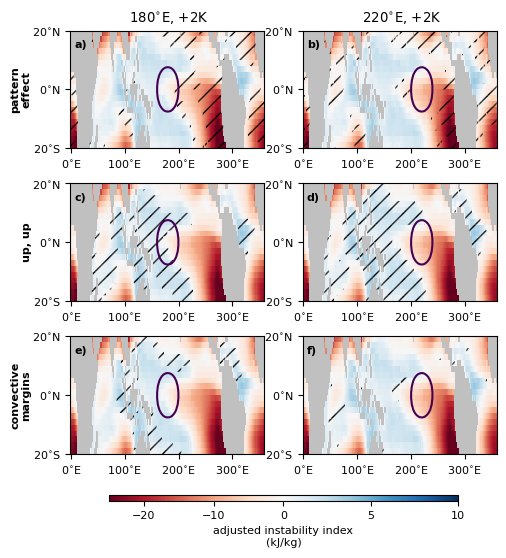

In [18]:
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]


lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)
n,m =len(lat), len(lon)
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, instability_ctrl_adjusted.sel(month = month), norm= divnorm, cmap = 'RdBu')
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, instability_ctrl_adjusted.sel(month = month), norm= divnorm, cmap = 'RdBu')
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, instability_ctrl_adjusted.sel(month = month), norm= divnorm, cmap = 'RdBu')
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, instability_ctrl_adjusted.sel(month = month), norm= divnorm, cmap = 'RdBu')
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])          
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]), ticks = [-20, -10, 0, 5, 10] ,orientation = 'horizontal', label = 'adjusted instability index\n(kJ/kg)')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)
fig1.savefig('newplots/Fig4.png', bbox_inches = 'tight', dpi = 300)

### Fig. S8: $\Delta$HCF as colorscale

HCF is defined per gridpoint as the max cloud fraction above 400hPa

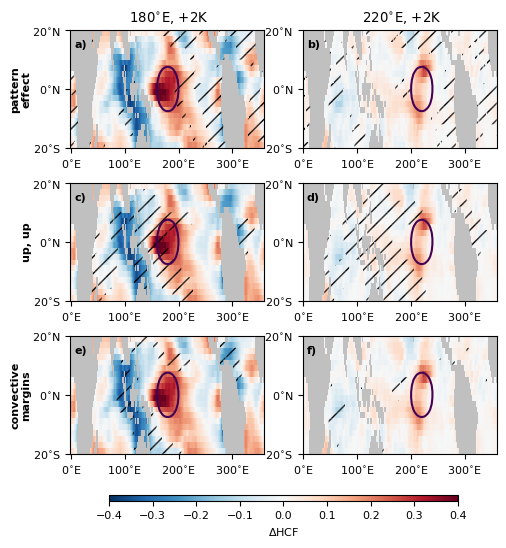

In [19]:
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]


lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)
n,m =len(lat), len(lon)
cf_ctrl = ds3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
hcf_ctrl = cf_ctrl.sel(plev = slice(100., 40000.)).max(dim = 'plev')
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        cf =  ds1_3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)

        #high cloud fraction
        hcf = cf.sel(plev = slice(100., 40000.)).max(dim = 'plev')

        delta_hcf = hcf - hcf_ctrl
        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])          
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]) ,orientation = 'horizontal', label = '$\Delta$HCF')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)
fig1.savefig('newplots/SIFig8.png', bbox_inches = 'tight', dpi = 300)

### Not in manuscript: $\Delta$LCF as colorscale

LCF is defined per gridpoint as the max cloud fraction between 1000hPa and 700hPa


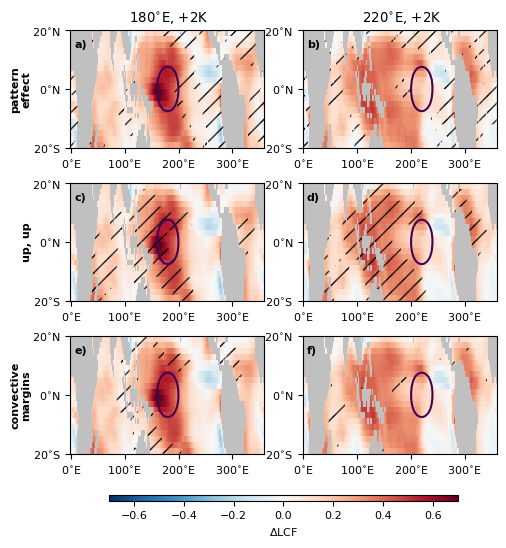

In [20]:
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]


lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)
n,m =len(lat), len(lon)
cf_ctrl = ds3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
hcf_ctrl = cf_ctrl.sel(plev = slice(60000., 100000.)).max(dim = 'plev')
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        cf =  ds1_3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)

        #high cloud fraction
        hcf = cf.sel(plev = slice(100., 40000.)).max(dim = 'plev')

        delta_hcf = hcf - hcf_ctrl
        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.7, vmax = 0.7, cmap = 'RdBu_r')
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, delta_hcf.sel(month = month), vmin = -0.7, vmax = 0.7,cmap = 'RdBu_r')
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])          
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]) ,orientation = 'horizontal', label = '$\Delta$LCF')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)

### Not in manuscript: $\Delta$CRE$_{net}$ as colorscale

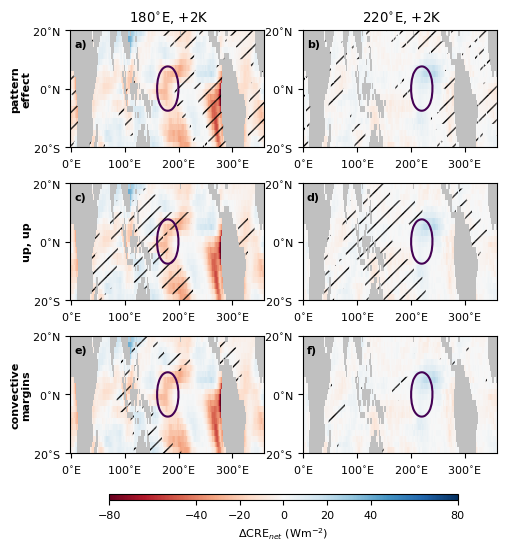

In [21]:
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]


lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1

n,m =len(lat), len(lon)
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, delta_netcre.sel(month = month), cmap = 'RdBu', vmin = [-80, 80])
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, delta_netcre.sel(month = month), cmap = 'RdBu', vmin = [-80, 80])
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, delta_netcre.sel(month = month), cmap = 'RdBu', vmin = [-80, 80])
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, delta_netcre.sel(month = month), cmap = 'RdBu', vmin = [-80, 80])
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])                    
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]), ticks = [-80, -40, -20, 0, 20, 40, 80], orientation = 'horizontal', label = '$\Delta$CRE$_{net}$ (Wm$^{-2}$)')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)
#fig1.savefig('newplots/CRE.png', bbox_inches = 'tight', dpi = 300)

### Not in manuscript: control CRE as colorscale

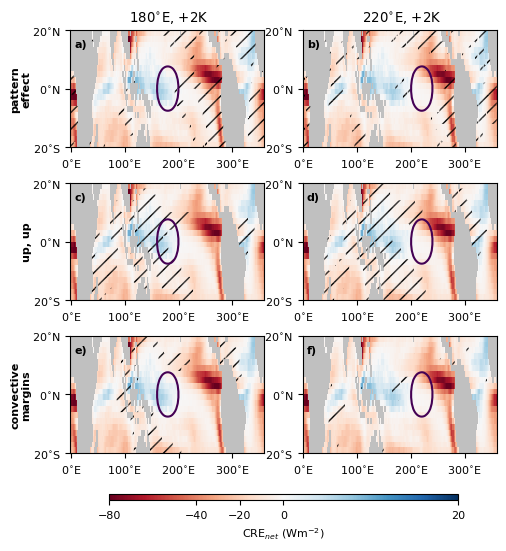

In [22]:
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]

divnorm = colors.TwoSlopeNorm(vmin = -80, vcenter = 0, vmax = 20)
lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1

n,m =len(lat), len(lon)
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, netcre_ctrl.sel(month = month), cmap = 'RdBu', norm= divnorm)
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, netcre_ctrl.sel(month = month), cmap = 'RdBu', norm  = divnorm)
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, netcre_ctrl.sel(month = month), cmap = 'RdBu', norm  = divnorm)
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, netcre_ctrl.sel(month = month), cmap = 'RdBu', norm  = divnorm)
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])                    
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]), ticks = [-80, -40, -20, 0, 20, 40, 80], orientation = 'horizontal', label = 'CRE$_{net}$ (Wm$^{-2}$)')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)
#fig1.savefig('newplots/CRE_clim.png', bbox_inches = 'tight', dpi = 300)

### Not in manuscript: cotnrol HCF

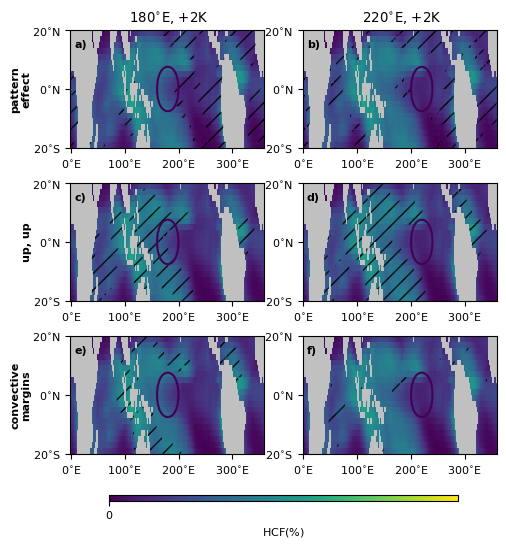

In [23]:
cf_ctrl = ds3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
hcf_ctrl = cf_ctrl.sel(plev = slice(100., 40000.)).max(dim = 'plev')
plt.rcParams.update({'font.size': 8})
gs_map = gridspec.GridSpec(3, 2)

fig1 = plt.figure()
ax_maps =[[plt.subplot(gs_map[0:1, 0]), plt.subplot(gs_map[1:2, 0]), plt.subplot(gs_map[2:3, 0])],
          [plt.subplot(gs_map[0:1,1]), plt.subplot(gs_map[1:2,1]), plt.subplot(gs_map[2:3,1])]]

divnorm = colors.TwoSlopeNorm(vmin = -80, vcenter = 0, vmax = 20)
lets = [['a)', 'c)', 'e)'],[ 'b)','d)', 'f)']]
month = 1

n,m =len(lat), len(lon)
for k in [2,3]:

    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        netcre = swcre + lwcre
        delta_netcre = netcre - netcre_ctrl
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        # pattern effect
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted<0,0).where(instability_adjusted<0,0).where(delta_netcre<0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][0].text(0.02, 0.85, lets[k-2][0], transform=ax_maps[k-2][0].transAxes, weight = 'bold')
        ax_maps[k-2][0].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        if k==2:
             cs = ax_maps[k-2][0].pcolormesh(lon, lat, hcf_ctrl.sel(month = month), vmin = 0, vmax = 1)
        else:
            ax_maps[k-2][0].pcolormesh(lon, lat, hcf_ctrl.sel(month = month), vmin = 0, vmax = 1)
        ax_maps[k-2][0].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        ax_maps[k-2][0].set_title(patch_title[k] + ', ' + delta_sst + 'K')
        if k==2:
            ax_maps[k-2][0].set_ylabel('pattern\neffect', weight = 'bold')
            ax_maps[k-2][0].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][0].transAxes)
        #add patch extent
        ax_maps[k-2][0].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        # up, up
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted>0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][1].text(0.02, 0.85, lets[k-2][1], transform=ax_maps[k-2][1].transAxes, weight = 'bold')
        ax_maps[k-2][1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][1].pcolormesh(lon, lat, hcf_ctrl.sel(month = month),  vmin = 0, vmax = 1)
        ax_maps[k-2][1].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][1].set_ylabel('up, up', weight = 'bold')
            ax_maps[k-2][1].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][1].transAxes)
        #add patch extent
        ax_maps[k-2][1].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month,lon = slice(150, 280)), levels = [1])

        
        # up, down
        count_map = xr.ones_like(instability_ctrl).where(instability_ctrl_adjusted>0,0).where(instability_adjusted<0,0) ## this is the line which defines the locations
        count_map = count_map.where((count_map)!=0, np.nan)
        ax_maps[k-2][2].text(0.02, 0.85, lets[k-2][2], transform=ax_maps[k-2][2].transAxes, weight = 'bold')
        ax_maps[k-2][2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
        ax_maps[k-2][2].pcolormesh(lon, lat, hcf_ctrl.sel(month = month), vmin = 0, vmax = 1)
        ax_maps[k-2][2].pcolor(lon, lat, count_map.sel(month = month), hatch = '//', alpha = 0)
        if k==2:
            ax_maps[k-2][2].set_ylabel('convective\nmargins', weight = 'bold')
            ax_maps[k-2][2].yaxis.set_label_coords(-0.2, 0.5, transform=ax_maps[k-2][2].transAxes)
        #add patch extent
        ax_maps[k-2][2].contour(lon.sel(lon = slice(150, 280)), lat, (ts - ts_ctrl).sel(month = month, lon = slice(150, 280)), levels = [1])
        
plt.setp(ax_maps, yticks = [-20, 0, 20], yticklabels = ['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'], xticks = [0, 100, 200, 300], xticklabels = ['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])                    
plt.colorbar(cs, ax = ax_maps[0][0], cax = ax_maps[0][1].inset_axes([0.2, -1.7, 1.8, 0.05]), ticks = [-80, -40, -20, 0, 20, 40, 80], orientation = 'horizontal', label = 'HCF($\%$)')     
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
fig1.set_size_inches(5.5,5.5)
#fig1.savefig('newplots/HCF_clim.png', bbox_inches = 'tight', dpi = 300)

### Fig. S7: cloud profile response in different regimes
mean change in cloud profiles in the different regimes (as defined above), with the `up,up' regions split further into points directly heated by the temperature pertubation and those not directly heated, as detailed in text. 

In particular: cloud fraction, cloud liquid water, cloud ice

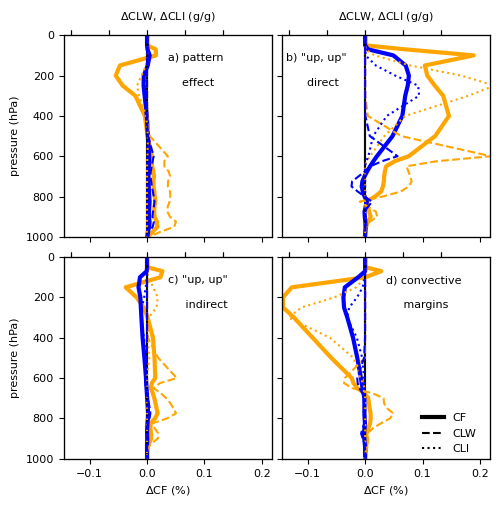

In [25]:
plt.rcParams.update({'font.size': 8})
fig = plt.figure()
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan = 2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan = 2)
ax3 = plt.subplot2grid((2, 4), (1, 0), colspan = 2)
ax4 = plt.subplot2grid((2, 4), (1, 2), colspan = 2)
axes = [ax1,ax2,ax3,ax4]
lets = ['a)', 'b)', 'c)', 'd)']

ones = xr.DataArray(data = np.ones((len(months), len(lat), len(lon))), dims=["month", "lat", "lon"])

mse_lims = [-5,5]
clw_lims = [-1.1E-5, 1.65E-5]
clw_ticks = [-1E-5, -0.5E-5, 0, 0.5E-5, 1E-5]
cf_lims = [-0.145, 0.2175]
regimes = ['pattern effect', '"up, up", direct', '"up, up", indirect', 'convective margins']
for k in [2,3]:
    #re-load
    instability_ctrl_adjusted = (hsfc_ctrl_adjusted - hsat500_ctrl).where(landmask.notnull()==False)
    
    patch = patches[k]
    patch_ex =  patch_extents[k]

    for j in [5]:
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        #vertical velocity
        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
        
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram
        cf = ds1_3d.cl.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
        cli = ds1_3d.cli.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
        clw = ds1_3d.clw.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
        
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #entrainment adjustment from perturbation simulation
        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = xr.DataArray(adjustment, dims=("month", "lat","lon")) *units.joule / units.kilogram
        
        hsfc_adjusted =  hsfc -ehat*adjustment 
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        instability_adjusted = hsfc_adjusted - hsat500

        swcre = ds1.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        lwcre = ds1.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds1.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        delta_lwcre = lwcre - lwcre_ctrl
        delta_swcre = swcre - swcre_ctrl

        delta_netcre = delta_lwcre + delta_swcre

        r1 = ones.where(instability_ctrl_adjusted<0).where(instability_adjusted<0).where(delta_netcre <0).where(landmask.notnull()==False)
        r2 = ones.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).where(patch_ex.notnull()==True).where(landmask.notnull()==False)
        r3 = ones.where(instability_ctrl_adjusted>0).where(instability_adjusted>0).where(patch_ex.notnull()==False).where(landmask.notnull()==False)
        r4 = ones.where(instability_ctrl_adjusted>0).where(instability_adjusted<0).where(landmask.notnull()==False)

        ## cloud fraction        
        reg1 = cf.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2 = cf.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3 = cf.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4 = cf.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        
        reg1_ctrl = cf_ctrl.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2_ctrl = cf_ctrl.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3_ctrl = cf_ctrl.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4_ctrl = cf_ctrl.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})

        
        #all patches, +2K
        if j==5:
            
            ax1.plot(reg1 - reg1_ctrl,p_in_hPa,  '-', linewidth = 3, color = patch_cols[k], label = 'CF')
            ax2.plot(reg2 - reg2_ctrl,p_in_hPa,  '-', linewidth = 3, color = patch_cols[k])
            ax3.plot(reg3 - reg3_ctrl, p_in_hPa, '-', linewidth = 3, color = patch_cols[k])
            ax4.plot(reg4 - reg4_ctrl, p_in_hPa, '-', linewidth = 3, color = patch_cols[k])
            [axes[dd].plot([0,0], [0,1000], 'k-', alpha = 0.8) for dd in range(4)]
            [axes[dd].set_xlim(cf_lims) for dd in range(4)]
            
        #repeat for clw
        reg1_clw = clw.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2_clw = clw.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3_clw = clw.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4_clw = clw.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        
        reg1_ctrl_clw = clw_ctrl.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2_ctrl_clw = clw_ctrl.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3_ctrl_clw = clw_ctrl.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4_ctrl_clw = clw_ctrl.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})

        #repeat for cli
        reg1_cli = cli.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2_cli = cli.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3_cli = cli.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4_cli = cli.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        
        reg1_ctrl_cli = cli_ctrl.where(r1==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg2_ctrl_cli = cli_ctrl.where(r2==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg3_ctrl_cli = cli_ctrl.where(r3==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        reg4_ctrl_cli = cli_ctrl.where(r4==1.0).weighted(weights).mean(dim = {'lat', 'lon', 'month'})
        
        if j==5:
            ax9 = ax1.twiny()
            ax9.plot((reg1_clw - reg1_ctrl_clw),p_in_hPa,  '--', color = patch_cols[k], label = 'CLW')
            ax9.plot((reg1_cli - reg1_ctrl_cli),p_in_hPa,  ':', color = patch_cols[k], label = 'CLI')
            ax9.set_xlim(clw_lims)
            ax9.set_xticks(clw_ticks)
            if k==2:
                ax9.set_xlabel('$\Delta$CLW, $\Delta$CLI (g/g)')
            
            
            ax10 = ax2.twiny()
            ax10.plot((reg2_clw - reg2_ctrl_clw),p_in_hPa,  '--', color = patch_cols[k])
            ax10.plot((reg2_cli - reg2_ctrl_cli),p_in_hPa,  ':', color = patch_cols[k])
            ax10.set_xlim(clw_lims)
            ax10.set_xticks(clw_ticks)
            if k==2:
                ax10.set_xlabel('$\Delta$CLW, $\Delta$CLI (g/g)')

            ax11 = ax3.twiny()
            ax11.plot((reg3_clw - reg3_ctrl_clw), p_in_hPa, '--', color = patch_cols[k])
            ax11.plot((reg3_cli - reg3_ctrl_cli), p_in_hPa, ':', color = patch_cols[k])
            ax11.set_xlim(clw_lims)
            ax11.set_xticks(clw_ticks)

            ax12 = ax4.twiny()
            ax12.plot((reg4_clw - reg4_ctrl_clw), p_in_hPa, '--', color = patch_cols[k])
            ax12.plot((reg4_cli - reg4_ctrl_cli), p_in_hPa, ':', color = patch_cols[k])
            ax12.set_xlim(clw_lims)
            ax12.set_xticks(clw_ticks)

            ax9.set_xticklabels('')
            ax10.set_xticklabels('')
            ax11.set_xticklabels('')
            ax12.set_xticklabels('')

l1 = Line2D([0], [0], color='k', lw=3)
l2 = Line2D([0], [0], color='k', linestyle = '--')
l3= Line2D([0], [0], color='k', linestyle = ':')
#['cloud fraction', 'cloud liquid water', 'cloud liquid ice']
ax12.legend([l1, l2, l3], ['CF', 'CLW', 'CLI'], loc = (0.65,0),frameon = False)
axes[0].text(0.5, 0.87, lets[0] + ' pattern' , transform=axes[0].transAxes)
axes[0].text(0.5, 0.75, '    effect' , transform=axes[0].transAxes)
axes[1].text(0.02, 0.87, lets[1] + ' "up, up"'  , transform=axes[1].transAxes)
axes[1].text(0.02, 0.75, '      direct', transform=axes[1].transAxes)

axes[2].text(0.5, 0.87, lets[2] + ' "up, up"'  , transform=axes[2].transAxes)
axes[2].text(0.5, 0.75, '     indirect', transform=axes[2].transAxes)

axes[3].text(0.5, 0.87, lets[3] + ' convective'  , transform=axes[3].transAxes)
axes[3].text(0.5, 0.75, '     margins', transform=axes[3].transAxes)

#[axes[dd].text(0.48, 0.87, lets[dd] + ' ' +regimes[dd] , transform=axes[dd].transAxes) for dd in [0,2,3]]
#[axes[dd].text(0.02, 0.87, lets[dd] + ' ' +regimes[dd] , transform=axes[dd].transAxes) for dd in [1]]
#[axes[dd].text(0.05, 0.05, , transform=axes[dd].transAxes) for dd in range(3)]
plt.setp(axes, ylim = [1000, 0])
plt.setp([axes[2], axes[3]], xlabel = '$\Delta$CF (%)')
plt.setp([axes[0], axes[1]], xticklabels = '')
plt.setp([axes[0], axes[2]], ylabel = 'pressure (hPa)')
plt.setp([axes[1], axes[3]], yticklabels = '')
fig.subplots_adjust(wspace= 0.1, hspace = 0.1)
fig.set_size_inches(5.5,5.5)
fig.savefig('newplots/SIFig7.png', bbox_inches = 'tight', dpi = 300)
